# AI for Experimental Controls Project
## GP Model for Autonomous Control of CDC High Voltage to Stabilize Gain

This notebook includes code used to train the sklearn GP model using a pressure-balanced training data set.

This notebook also includes code and plots used to evaluate the GP model over the range of possible atmospheric pressures, temperature, and currents.


In [1]:
# import needed libraries
# the basics
import os
import time
import numpy as np
import pandas as pd

# visualization
from matplotlib import pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# modeling and evaluation
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, RationalQuadratic as RQ, WhiteKernel, ExpSineSquared as Exp, DotProduct as Lin
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import scipy.stats as stats

# for saving the model
from pickle import dump

# display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# random seed
np.random.seed(1)

# ignore warnings
import warnings
warnings. filterwarnings('ignore')

# import local functions
import create_sklearn_gpr as gpr

In [2]:
# feature columns: pressure, temp, and (temp + current)
cols_best =  ['PRESSURE_MEAN','D1_MAX','SUM_D1_MAX_MEAN_A_MEAN']
# target column: GAIN
cols_target = ['GAIN']

In [3]:
# 2021 and 2020 data: training
df_train = pd.read_csv('../D-data-CDC/Balanced_2021_2020_GCF_Train.csv')
print('Train data shape: ',df_train.shape)
# test
df_test = pd.read_csv('../D-data-CDC/Balanced_2021_2020_GCF_Test.csv')
print('Test data shape: ', df_test.shape)

# both train and test data
df = pd.read_csv('../D-data-CDC/2021_2020_GCF_All.csv')
print("Train and Test shape: ",df.shape)

Train data shape:  (480, 7)
Test data shape:  (121, 7)
Train and Test shape:  (601, 7)


Training Time: 16.1967 seconds
Trained Kernel Parameters:  {'k1': RBF(length_scale=1.42), 'k2': WhiteKernel(noise_level=0.0154), 'k1__length_scale': 1.4158649505569596, 'k1__length_scale_bounds': (1e-05, 100000.0), 'k2__noise_level': 0.015406469343369245, 'k2__noise_level_bounds': (1e-05, 100000.0)}
MSE:  3.1744230704013175e-06
MSE / mean GCF:  2.096395407168984e-05
Bad Run Numbers:  [[7.28140000e+04 6.12359958e+00]
 [7.20050000e+04 4.22909803e+00]
 [7.28160000e+04 3.71402953e+00]
 [7.18060000e+04 3.35483649e+00]]


Text(0, 0.5, 'Max Absolute % Error')

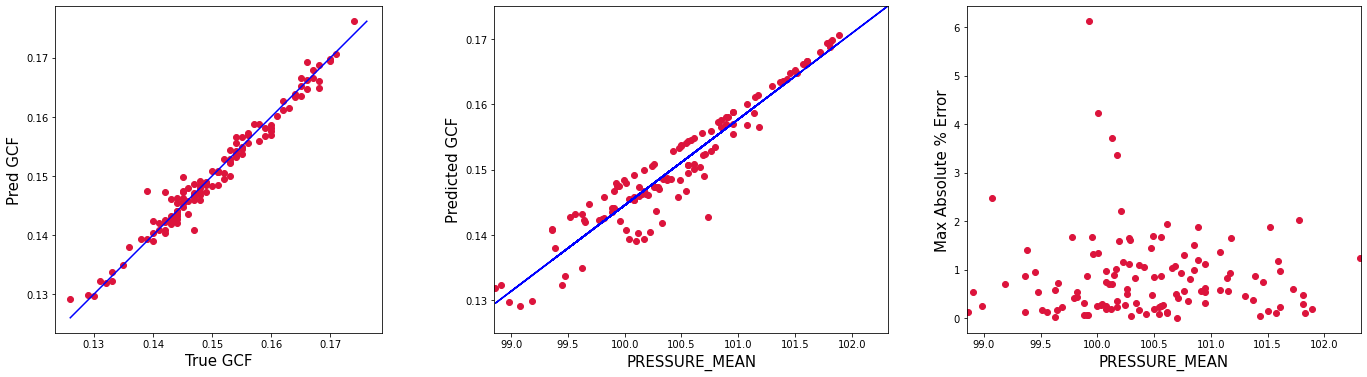

In [4]:
# get training and test features and targets
df_train_X = df_train[cols_best]
df_train_y = df_train[cols_target]

df_test_X = df_test[cols_best]
df_test_y = df_test[cols_target]
lst_test_RUNNUMBER = df_test['RUNNUMBER']

tic = time.perf_counter()

# scale the input and output
# input
scaler_train_X = StandardScaler()
scaler_train_X.fit(df_train_X)
train_array_X = scaler_train_X.transform(df_train_X)
test_array_X = scaler_train_X.transform(df_test_X)

# output
scaler_train_y = StandardScaler()
scaler_train_y.fit(df_train_y)
train_array_y = scaler_train_y.transform(df_train_y)
test_array_y = scaler_train_y.transform(df_test_y)

# save the scalars for each feature: D1_MAX, MEAN_A_MEAN, and SUM_D1_MAX_MEAN_A_MEAN
for col in ['PRESSURE_MEAN', 'D1_MAX', 'SUM_D1_MAX_MEAN_A_MEAN']:
    # create the scaler & fit to the data
    scaler = StandardScaler()
    x = df_train_X[[col]].to_numpy()
    scaler.fit(x)            

    # the filename will be: [i_prefix][COLUMN].gz
    #filename = 'scalar_' + col + '.pkl'
    # save the scaler
    #dump(scaler, open(os.path.join('scalars', filename), 'wb'))

for col in ['GAIN']:
    # create the scaler & fit to the data
    scaler = StandardScaler()
    x = df_train_y[[col]].to_numpy()
    scaler.fit(x)
    
    # the filename will be: [i_prefix][COLUMN].gz
    #filename = 'scalar_' + col + '.pkl'
    # save the scaler
    #dump(scaler, open(os.path.join('/home/dianam/Documents/AIEC/ML/D-ml-CDC/GAIN-GPR/scalars', filename), 'wb'))


# create the GPR model
gp = gpr.GPR_SkLearn(train_array_X, train_array_y, 40, [RBF(), WhiteKernel()])
# train the model
gp.train_model()
# get the time to train
toc = time.perf_counter()

print(f"Training Time: {toc - tic:0.4f} seconds")
print("Trained Kernel Parameters: ", gp.model.kernel_.get_params())

# predictions
preds_gcf_stdv = gp.predict(test_array_X)
# prediction: gain
preds_gcf = preds_gcf_stdv[0][:]

# invert the scale on preds_gcf
preds_inverse_gcf = scaler_train_y.inverse_transform(preds_gcf)

# stdv/uncertainty
preds_stdv = (preds_gcf_stdv[1][:]).reshape(-1, 1) 
# invert scale the stdv
# need to subtract the train_y mean from the stdv
preds_inverse_stdv = scaler_train_y.inverse_transform(preds_stdv) - df_train_y['GAIN'].mean() 

truth_pred_dif = abs(df_test_y['GAIN'] - preds_inverse_gcf[:,0])
perc_dif = abs(df_test_y['GAIN'] - preds_inverse_gcf[:,0]) / df_test_y['GAIN']

# mse
mse = mean_squared_error(df_test_y['GAIN'], preds_inverse_gcf)
print("MSE: ", mse)
print("MSE / mean GCF: ", mse / df_train_y['GAIN'].mean())

# find the worst predictions
dfPreds = df_test[['RUNNUMBER','GAIN','PRESSURE_MEAN']]
dfPreds.loc[:,'PRED'] = preds_inverse_gcf.flatten()
dfPreds.loc[:,'PRED_STD'] = preds_inverse_stdv
dfPreds.loc[:,'Perc_Diff'] = perc_dif
truth_pred_dif = abs(df_test_y.loc[:,'GAIN'] - preds_inverse_gcf[:,0])
perc_dif = abs(df_test_y.loc[:,'GAIN'] - preds_inverse_gcf[:,0]) / df_test_y.loc[:,'GAIN']
dfPreds.loc[:,'Perc_Diff'] = dfPreds['Perc_Diff'] * 100
str_bad_runs = str(dfPreds.sort_values(by='Perc_Diff', ascending=False).query('Perc_Diff > 3')[['RUNNUMBER','Perc_Diff']].to_numpy())[0:250]
print("Bad Run Numbers: ", str_bad_runs)

fig, axes = plt.subplots(1,3, figsize=(24, 6))

# create truth v pred plot for each run and save to mlflow artifacts
axes[0].scatter(df_test_y['GAIN'], preds_inverse_gcf[:,0], c='crimson')
p1 = max(max(preds_inverse_gcf[:,0]), max(df_test_y['GAIN']))
p2 = min(min(preds_inverse_gcf[:,0]), min(df_test_y['GAIN']))
axes[0].plot([p1, p2], [p1, p2], 'b-')
axes[0].set_xlabel('True GCF', fontsize=15)
axes[0].set_ylabel('Pred GCF', fontsize=15)
# set the axis to equal
axes[0].set_aspect('equal', 'box')

# predictions and prediction stats
df_Predictions = df_test_X
df_Predictions.loc[:,'RUNNUMBER'] = lst_test_RUNNUMBER
df_Predictions.loc[:,'GCF_TRUE'] = df_test_y.loc[:,'GAIN']
df_Predictions.loc[:,'GCF_PRED'] = preds_inverse_gcf
df_Predictions.loc[:,'GCF_PRED_STDV'] = preds_inverse_stdv

# create plot of predicted GCF by pressure with fit line
m, b = np.polyfit(dfPreds['PRESSURE_MEAN'], dfPreds['PRED'], 1)
x = dfPreds.loc[:,'PRESSURE_MEAN']

axes[1].scatter(dfPreds['PRESSURE_MEAN'], dfPreds['PRED'], c='crimson')
axes[1].plot(x, m*x + b, 'b-')
axes[1].set_xlim(dfPreds['PRESSURE_MEAN'].min() - 0.01, dfPreds['PRESSURE_MEAN'].max() + 0.01)
axes[1].set_ylim(dfPreds['GAIN'].min() - 0.001, dfPreds['GAIN'].max() + 0.001)
axes[1].set_xlabel('PRESSURE_MEAN', fontsize=15)
axes[1].set_ylabel('Predicted GCF', fontsize=15)

# create plot of error percent by pressure
axes[2].scatter(dfPreds['PRESSURE_MEAN'], dfPreds['Perc_Diff'], c='crimson')
axes[2].set_xlim(dfPreds['PRESSURE_MEAN'].min() - 0.01, dfPreds['PRESSURE_MEAN'].max() + 0.01)
axes[2].set_xlabel('PRESSURE_MEAN', fontsize=15)
axes[2].set_ylabel('Max Absolute % Error', fontsize=15)


### Make predictions
Determine time to make predictions

In [5]:
# single predictions
tic = time.perf_counter()
preds_gcf_stdv1 = gp.predict(test_array_X[0].reshape(1, -1))
toc = time.perf_counter()
print(f"Prediction time: {toc - tic:0.4f} seconds")


Prediction time: 0.0018 seconds


In [6]:
df_Predictions.loc[:,'MEAN_A_MEAN'] = df_Predictions['SUM_D1_MAX_MEAN_A_MEAN'] - df_Predictions['D1_MAX']
df_Predictions.head()

,PRESSURE_MEAN,D1_MAX,SUM_D1_MAX_MEAN_A_MEAN,RUNNUMBER,GCF_TRUE,GCF_PRED,GCF_PRED_STDV,MEAN_A_MEAN
0,99.1841,299.55,299.900734,81538,0.129,0.129903,0.001465,0.350734
1,99.0765,299.55,299.898559,81539,0.126,0.129124,0.001573,0.348559
2,98.9837,299.65,300.066710,81652,0.130,0.129666,0.001334,0.416710
3,100.1030,299.45,300.954721,81527,0.140,0.139011,0.001253,1.504721
4,100.1200,299.55,301.497449,81529,0.140,0.140267,0.001245,1.947449


In [7]:
df_Predictions.describe()

,PRESSURE_MEAN,D1_MAX,SUM_D1_MAX_MEAN_A_MEAN,RUNNUMBER,GCF_TRUE,GCF_PRED,GCF_PRED_STDV,MEAN_A_MEAN
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,100.449750,299.565702,307.511924,73496.661157,0.150430,0.150443,0.001267,7.946221
std,0.705405,0.419724,3.154649,3101.810110,0.010002,0.009758,0.000195,3.094366
min,98.862000,299.050000,299.337500,71363.000000,0.126000,0.129124,0.001187,0.187500
25%,100.010000,299.150000,307.493263,71910.000000,0.144000,0.144085,0.001195,8.343263
50%,100.370000,299.250000,308.509050,72418.000000,0.149000,0.148551,0.001204,9.202575
75%,100.890000,300.050000,309.433425,73065.000000,0.156000,0.156821,0.001244,9.707138
max,102.310000,300.250000,310.769000,81668.000000,0.174000,0.176163,0.002607,10.619000


## 2D Surface Plots for range of pressure, temp, and current


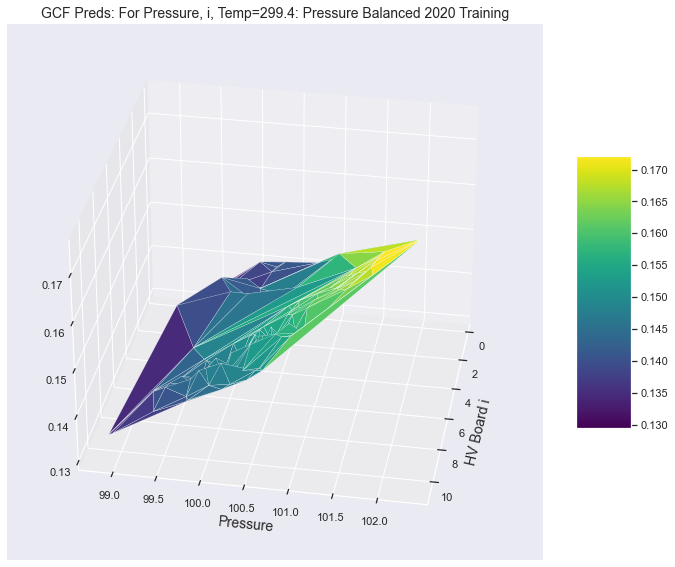

In [8]:
sns.set(rc = {'figure.figsize':(12,10)})

# Pressure Balanced 2020 and 2021 Training"
fig = plt.figure()
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df_Predictions['MEAN_A_MEAN'], df_Predictions['PRESSURE_MEAN'], df_Predictions['GCF_PRED'], cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, 10)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel("HV Board i", fontsize = 14)
ax.set_ylabel("Pressure", fontsize = 14)
ax.set_title("GCF Preds: For Pressure, i, Temp=299.4: Pressure Balanced 2020 Training", fontsize = 14)
plt.show()



### Predictions Generated Across the Range of pressure and current
* pressures between 95 - 105
* temp set to: 299.4
* current between: 0 - 12

Text(0.5, 1.0, 'GCF Pred Stdv For Pressure, Current, Temp Fixed At 299.4')

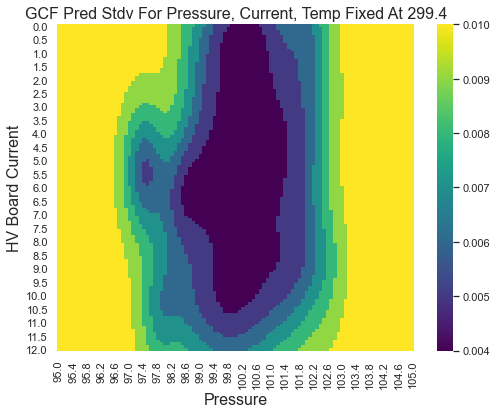

In [9]:
df_GeneratedPreds_WithStdv = pd.read_csv('../D-data-CDC/preds_withstdv.csv')
df_GeneratedPreds_WithStdv['MEAN_A_MEAN'] = [s-t for t,s in zip(df_GeneratedPreds_WithStdv['D1_MAX'],df_GeneratedPreds_WithStdv['SUM_D1_MAX_MEAN_A_MEAN'])] 

sns.set(rc = {'figure.figsize':(8,6)})

df_Surface = df_GeneratedPreds_WithStdv.round(3)
df_Surface = df_Surface.pivot('MEAN_A_MEAN', 'PRESSURE_MEAN', 'GCF_PRED_STDV')
ax = sns.heatmap(df_Surface, cmap=plt.cm.viridis, linewidth=0.001)

ax.set_xlabel("Pressure", fontsize = 16)
ax.set_ylabel("HV Board Current", fontsize = 16)
ax.set_title("GCF Pred Stdv For Pressure, Current, Temp Fixed At 299.4", fontsize = 16)

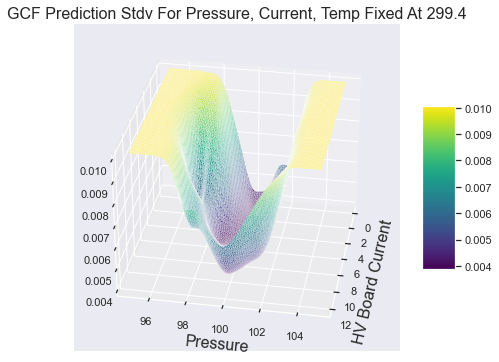

In [10]:
sns.set(rc = {'figure.figsize':(8,6)})

fig = plt.figure()
ax = fig.gca(projection='3d')
surf=ax.plot_trisurf(df_GeneratedPreds_WithStdv['MEAN_A_MEAN'], df_GeneratedPreds_WithStdv['PRESSURE_MEAN'], df_GeneratedPreds_WithStdv['GCF_PRED_STDV'], cmap=plt.cm.viridis, linewidth=0.2)
ax.view_init(30, 10)
fig.colorbar( surf, shrink=0.5, aspect=5)
ax.set_xlabel("HV Board Current", fontsize = 16)
ax.set_ylabel("Pressure", fontsize = 16)

ax.set_title("GCF Prediction Stdv For Pressure, Current, Temp Fixed At 299.4", fontsize = 16)
plt.show()

Text(0.5, 1.0, 'GCF Predictions For Pressure, Current, Temp Fixed At 299.4')

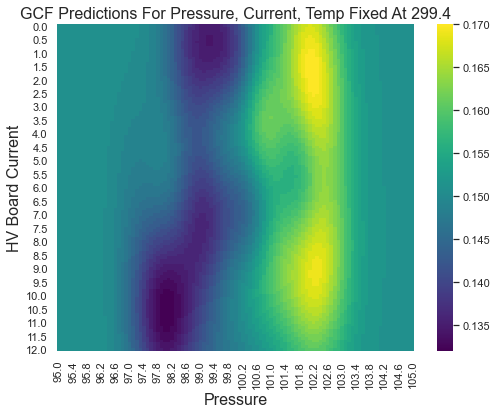

In [11]:
sns.set(rc = {'figure.figsize':(8,6)}) 

df_Surface = df_GeneratedPreds_WithStdv.round(3)
df_Surface = df_Surface.pivot('MEAN_A_MEAN', 'PRESSURE_MEAN', 'GCF_PRED')
ax = sns.heatmap(df_Surface, cmap=plt.cm.viridis, linewidth=0.001)

ax.set_xlabel("Pressure", fontsize = 16)
ax.set_ylabel("HV Board Current", fontsize = 16)
ax.set_title("GCF Predictions For Pressure, Current, Temp Fixed At 299.4", fontsize = 16)

### Demonstration using the functions that were used during the cosmics run to load the model and retrieve a prediction

In [12]:
os.chdir('../utilities/CDC_control_ai')

In [13]:

# get the testing range data and set current == 0.4
df_testing_loop = df_GeneratedPreds_WithStdv[['PRESSURE_MEAN','MEAN_A_MEAN','D1_MAX']]
df_testing_loop['MEAN_A_MEAN'] = 0.4
df_testing_loop['pred'] = 0.
df_testing_loop['pred_stdv'] = 0.
df_testing_loop.columns = ['pressure','current','temp','pred','pred_stdv']
print(df_testing_loop.shape)
df_testing_loop = df_testing_loop.drop_duplicates(ignore_index = True)
print(df_testing_loop.shape)
df_testing_loop.head()

  

(12221, 5)
(101, 5)


,pressure,current,temp,pred,pred_stdv
0,95.0,0.4,299.4,0.0,0.0
1,95.1,0.4,299.4,0.0,0.0
2,95.2,0.4,299.4,0.0,0.0
3,95.3,0.4,299.4,0.0,0.0
4,95.4,0.4,299.4,0.0,0.0


In [14]:
from cosmics import cdc_loadmodel as loadmodel
gp_model, params = loadmodel.load_model('cosmics/d_cdc_modelneeds/model_pickle4.pkl')
print(gp_model)
print(params)

from cosmics import cdc_runai as runai
preds = []
stdvs = []

for i in range(len(df_testing_loop)):
    current = df_testing_loop.loc[i, "current"]
    pressure = df_testing_loop.loc[i, "pressure"]
    temp = df_testing_loop.loc[i, "temp"]
                
    model_inputs = {'pressure':pressure,'temp':temp,'current':current}
    gcf, gcf_stdv, _ = runai.predict_gcf(gp_model, params, model_inputs)
                
    preds.append(gcf)
    stdvs.append(gcf_stdv)
    
print(preds[0:5])
print(stdvs[0:5])

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=100, random_state=0)
{'D1_MAX': StandardScaler(), 'GAIN': StandardScaler(), 'PRESSURE_MEAN': StandardScaler(), 'SUM_D1_MAX_MEAN_A_MEAN': StandardScaler(), 'MEAN_GCF': 0.1528}
[0.15148137625345776, 0.1513368411372494, 0.15118031084532807, 0.1510112662832491, 0.15082922854725617]
[0.008844151807858497, 0.008838324735236547, 0.008831176748276631, 0.008822452429469274, 0.008811858920177634]


## Across range of pressure and temp show the GCF predictions and standard deviations

Also show the training observations.

In [22]:
df_testing_loop_20202021 = pd.read_csv('../../D-data-CDC/preds_sklearnGPR_Trained20202021.csv')
df_testing_loop_20202021 = df_testing_loop_20202021.round(3)
df_testing_loop_20202021.columns = ['pressure','temp','sum','pred','pred_stdv']
df_testing_loop_20202021['current'] = [s-t for t,s in zip(df_testing_loop_20202021['temp'],df_testing_loop_20202021['sum'])]
df_testing_loop_20202021 = df_testing_loop_20202021.round(3)

df_testing_loop_20202021 = df_testing_loop_20202021.query('current == 0.4')
df_testing_loop_20202021 = df_testing_loop_20202021[['pressure','current','temp','pred','pred_stdv']]
df_testing_loop_20202021 = df_testing_loop_20202021.drop_duplicates(ignore_index = True)
print(df_testing_loop_20202021.shape)
df_testing_loop_20202021.head()

(2800, 5)


,pressure,current,temp,pred,pred_stdv
0,96.0,0.4,297.0,0.151,0.01
1,96.0,0.4,297.1,0.151,0.01
2,96.0,0.4,297.2,0.151,0.01
3,96.0,0.4,297.3,0.151,0.01
4,96.0,0.4,297.4,0.151,0.01


In [23]:
df_testing_loop_20202021.describe()

,pressure,current,temp,pred,pred_stdv
count,2800.000000,2800.0,2800.000000,2800.000000,2800.000000
mean,99.450000,0.4,298.950000,0.149277,0.007958
std,2.020881,0.0,1.154546,0.006825,0.002802
min,96.000000,0.4,297.000000,0.127000,0.001000
25%,97.700000,0.4,297.975000,0.148000,0.007000
50%,99.450000,0.4,298.950000,0.151000,0.009000
75%,101.200000,0.4,299.925000,0.152000,0.010000
max,102.900000,0.4,300.900000,0.164000,0.010000


In [24]:
# get the 2020 and 2021 training data
df_20202021 = pd.read_csv('../../D-data-CDC/2021_2020_GCF_All.csv')
print(df_20202021.shape)
df_20202021.columns=['run','pressure','temp','current','sum_temp_current','gain','rp']
df_20202021['pressure_index'] = ((np.round(df_20202021['pressure'],1) - 96) * 10).astype('int64')
df_20202021['temp_index'] = ((np.round(df_20202021['temp'],1) - 297) * 10).astype('int64')
df_20202021.head()

(601, 7)


,run,pressure,temp,current,sum_temp_current,gain,rp,pressure_index,temp_index
0,81655,99.1310,299.65,0.414975,300.064975,0.132,RP_2021,30,26
1,81656,99.2560,299.65,0.428880,300.078880,0.133,RP_2021,32,26
2,81651,98.9373,299.75,0.438275,300.188274,0.130,RP_2021,29,28
3,81649,98.8928,299.65,0.397487,300.047487,0.129,RP_2021,29,26
4,81650,98.9320,299.75,0.340197,300.090197,0.129,RP_2021,29,28


Text(0.5, 1.0, 'Trained 2020-2021 Data Predicted Stdvs: Current @ 0.4')

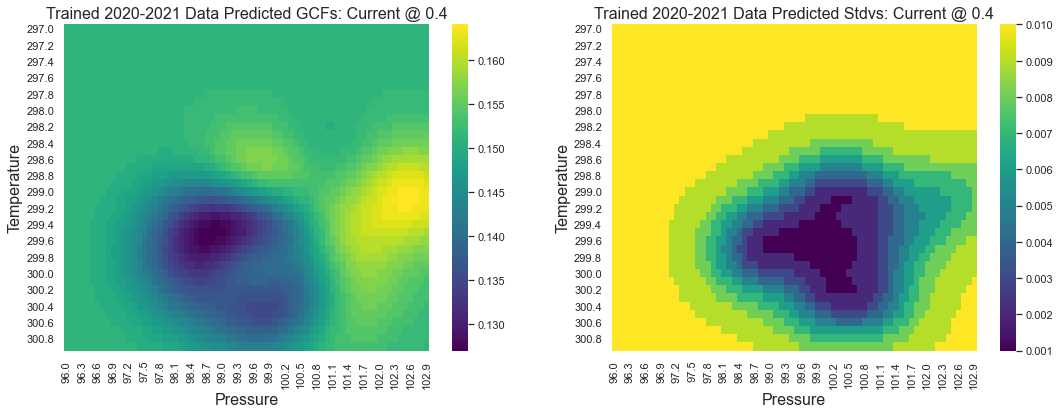

In [28]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))

df_Surface = df_testing_loop_20202021.pivot('temp', 'pressure', 'pred')
sns.heatmap(df_Surface, cmap=plt.cm.viridis, linewidth=0.001, ax=axes[0])
axes[0].set_xlabel("Pressure", fontsize = 16)
axes[0].set_ylabel("Temperature", fontsize = 16)
axes[0].set_title("Trained 2020-2021 Data Predicted GCFs: Current @ 0.4", fontsize = 16)

df_Surface = df_testing_loop_20202021.pivot('temp', 'pressure', 'pred_stdv')
sns.heatmap(df_Surface, cmap=plt.cm.viridis, linewidth=0.001, ax=axes[1])
axes[1].set_xlabel("Pressure", fontsize = 16)
axes[1].set_ylabel("Temperature", fontsize = 16)
axes[1].set_title("Trained 2020-2021 Data Predicted Stdvs: Current @ 0.4", fontsize = 16)


Text(0.5, 1.0, 'Prediction standard deviations: current at 0.4')

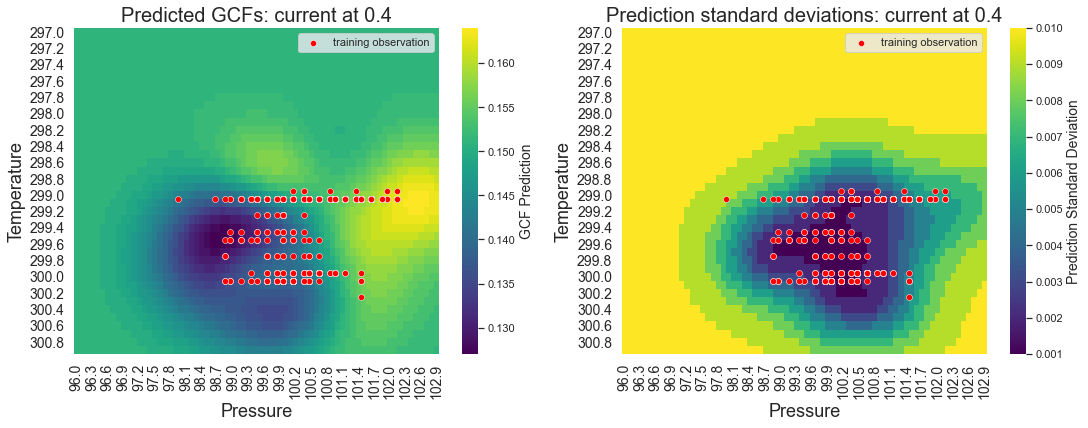

In [30]:

fig, axes = plt.subplots(1,2, figsize=(18, 6))

df_Surface = df_testing_loop_20202021.pivot('temp', 'pressure', 'pred')
sns.heatmap(df_Surface, cmap=plt.cm.viridis, linewidth=0.001, zorder=-1, ax=axes[0])
axes[0].autoscale(False)
sns.scatterplot(data=df_20202021, x='pressure_index', y='temp_index', color="red", zorder=100, ax=axes[0], label='training observation')
axes[0].set_xlabel("Pressure", fontsize = 18)
axes[0].set_ylabel("Temperature", fontsize = 18)
axes[0].tick_params(axis='y', labelsize=14 )
axes[0].tick_params(axis='x', labelsize=14 )
axes[0].collections[0].colorbar.set_label("GCF Prediction", fontsize=14)
axes[0].set_title("Predicted GCFs: current at 0.4", fontsize = 20)

df_Surface = df_testing_loop_20202021.pivot('temp', 'pressure', 'pred_stdv')
sns.heatmap(df_Surface, cmap=plt.cm.viridis, linewidth=0.001, ax=axes[1])
axes[1].autoscale(False)
sns.scatterplot(data=df_20202021, x='pressure_index', y='temp_index', color="red", zorder=100, ax=axes[1], label='training observation')
axes[1].set_xlabel("Pressure", fontsize = 18)
axes[1].set_ylabel("Temperature", fontsize = 18)
axes[1].tick_params(axis='y', labelsize=14 )
axes[1].tick_params(axis='x', labelsize=14 )
axes[1].collections[0].colorbar.set_label("Prediction Standard Deviation", fontsize=14)
axes[1].set_title("Prediction standard deviations: current at 0.4", fontsize = 20)

### Determine the number of predictions within 1, 2, and 3 standard deviations

In [36]:
df_Predictions['1s_high'] = df_Predictions['GCF_PRED'] + df_Predictions['GCF_PRED_STDV']
df_Predictions['1s_low'] = df_Predictions['GCF_PRED'] - df_Predictions['GCF_PRED_STDV']
df_Predictions['2s_high'] = df_Predictions['GCF_PRED'] + 2*df_Predictions['GCF_PRED_STDV']
df_Predictions['2s_low'] = df_Predictions['GCF_PRED'] - 2*df_Predictions['GCF_PRED_STDV']
df_Predictions['3s_high'] = df_Predictions['GCF_PRED'] + 3*df_Predictions['GCF_PRED_STDV']
df_Predictions['3s_low'] = df_Predictions['GCF_PRED'] - 3*df_Predictions['GCF_PRED_STDV']
df_Predictions['within_1s'] = [1 if t >= p and t <= q else 0 for t,p,q in zip(df_Predictions['GCF_TRUE'], df_Predictions['1s_low'], df_Predictions['1s_high'])]
df_Predictions['within_2s'] = [1 if t >= p and t <= q else 0 for t,p,q in zip(df_Predictions['GCF_TRUE'], df_Predictions['2s_low'], df_Predictions['2s_high'])]
df_Predictions['within_3s'] = [1 if t >= p and t <= q else 0 for t,p,q in zip(df_Predictions['GCF_TRUE'], df_Predictions['3s_low'], df_Predictions['3s_high'])]

print("Within 1 standard deviation: ", np.round(df_Predictions['within_1s'].sum()/df_Predictions.shape[0] * 100,1), "%")
print("Within 2 standard deviations: ", np.round(df_Predictions['within_2s'].sum()/df_Predictions.shape[0] * 100,1), "%")
print("Within 3 standard deviations: ", np.round(df_Predictions['within_3s'].sum()/df_Predictions.shape[0] * 100,1), "%")

Within 1 standard deviation:  59.5 %
Within 2 standard deviations:  89.3 %
Within 3 standard deviations:  97.5 %


### Determine the reduced chi-squared for the predictions

In [39]:
chisq=np.sum(((df_Predictions['GCF_TRUE']-df_Predictions['GCF_PRED'])/df_Predictions['GCF_PRED_STDV'])**2 )
nu=len(df_Predictions['GCF_TRUE'])-1-3
print("chi squared: :",chisq)
print("df: :",nu)
print("chi squared reduced: :",chisq/nu)
  

chi squared: : 184.70823425351455
df: : 117
chi squared reduced: : 1.5787028568676458
